## Mixutre Density Network (MDN)

In this tutorial, we will design and train a mixture denisty network (MDN). Precisely speaking, MDN is a neural network framework that is a combination of (almost) any network architecture and mixture density model. Due to the mixture density model part, MDN can model flexibly parametric distributions. <br/>

<center><img src="img/mdn.png"><em>Mixture Density Network</em></center>

Hereby, we focus on MDN tpye which has a __MLP (multi layer perceptron)__ encoder and __GMM (Gaussian Mixture Model)__ as the decoding distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Modelling multimodal function

One strong point of MDN is its capability of modelling multimodal distribution. (or mathematically speaking, one-to-many map)

<center><img src="img/one_to_many_map.png"><em>Example of one-to-many map </em></center>

In [2]:
def generate_simple_data(n_samples):
    epsilon = np.random.normal(size=(n_samples)) # smaple noise from Gaussin dist with mean 0, std = 1.0
    x = np.random.uniform(-10.5, 10.5, n_samples)
    y = 7 * np.sin(0.75 * x) + 0.5 * x + epsilon
    return x, y

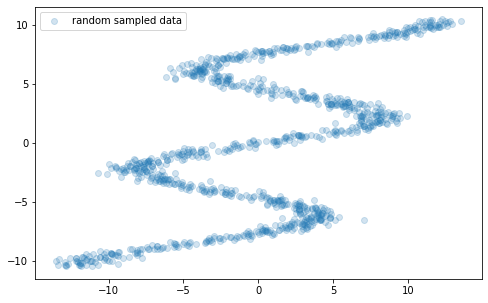

In [3]:
y, x = generate_simple_data(1000) # just swap x,y to generate 'many-to-one' mapping

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x,y, alpha=0.2, label='random sampled data')
plt.legend()
plt.show()

## Try to fit multimodal distribution with the Gaussian network


In [4]:
from src.GaussianNetwork import GaussianNetwork
from src.losses import gaussianLL

In [5]:
gaussianNet = GaussianNetwork(1, 100)

opt = torch.optim.Adam(gaussianNet.parameters())

In [6]:
x_tensor = torch.tensor(x).reshape(-1, 1).float()
y_tensor = torch.tensor(y).reshape(-1, 1).float()

## Visualizing the NOT trained model

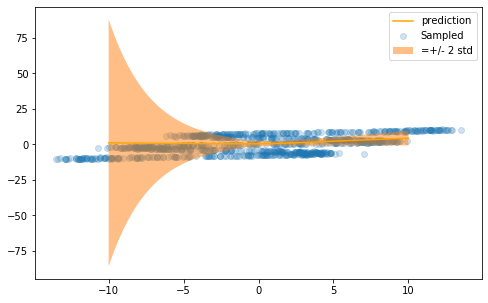

In [7]:
_x_tensor = torch.linspace(-10, 10, 100).reshape(-1,1)
mu, std = gaussianNet(_x_tensor)
N_STD = 2

x_axis = np.squeeze(_x_tensor.detach().numpy())
upper = mu + N_STD *std
upper_np = np.squeeze(upper.detach().numpy())

lower = mu - N_STD * std
lower_np = np.squeeze(lower.detach().numpy())

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x, y, alpha=0.2, label='Sampled')
ax.plot(x_axis, mu.detach().numpy(), color='orange', label='prediction')
ax.fill_between(x_axis, upper_np, lower_np, alpha=0.5, label='=+/- {} std'.format(N_STD))
plt.legend()
plt.show()

In [8]:
for i in range(1500):
    mu, std = gaussianNet(x_tensor)
    loss = gaussianLL(mu, std, y_tensor)
    loss = -loss.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

## Gaussian network is not capable of fitting ultimodal outcomes

Now we will see whether the Gaussian network can model 'multimodal' outcomes. The result is given as follows.

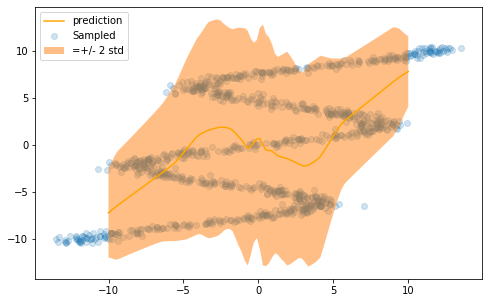

In [9]:
_x_tensor = torch.linspace(-10, 10, 100).reshape(-1,1)
mu, std = gaussianNet(_x_tensor)
N_STD = 2

x_axis = np.squeeze(_x_tensor.detach().numpy())
upper = mu + N_STD *std
upper_np = np.squeeze(upper.detach().numpy())

lower = mu - N_STD * std
lower_np = np.squeeze(lower.detach().numpy())

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x, y, alpha=0.2, label='Sampled')
ax.plot(x_axis, mu.detach().numpy(), color='orange', label='prediction')
ax.fill_between(x_axis, upper_np, lower_np, alpha=0.5, label='=+/- {} std'.format(N_STD))
plt.legend()
plt.show()

## Let's define MDN!

In [10]:
import torch.nn as nn

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden)
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

In [11]:
mdn = MDN(n_hidden=20, n_gaussians=5)

In [12]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma+1e-10)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma+1e-10)) * oneDivSqrtTwoPI

In [13]:
def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi    
    result = torch.sum(result, dim=1)
    result = -torch.log(result + 1e-10)
    return torch.mean(result)

In [14]:
opt = torch.optim.Adam(mdn.parameters())
loss_fn = mdn_loss_fn

In [15]:
for i in range(30000):
    pi, sigma, mu = mdn(x_tensor)
    loss = loss_fn(pi, sigma, mu, y_tensor)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i % 3000 == 0:
        print("[{} epoch] loss = {}".format(i, loss.item()))

[0 epoch] loss = 13.471033096313477
[3000 epoch] loss = 1.4617524147033691
[6000 epoch] loss = 1.4380017518997192
[9000 epoch] loss = 1.424289584159851
[12000 epoch] loss = 1.3237435817718506
[15000 epoch] loss = 1.3124715089797974
[18000 epoch] loss = 1.3016537427902222
[21000 epoch] loss = 1.2868151664733887
[24000 epoch] loss = 1.2785435914993286
[27000 epoch] loss = 1.2659591436386108


## Use gumbel trick: Reparamtrize catergorical distribution!

In [17]:
x_test_data = np.linspace(-15, 15, 1000)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(1000, 1))
pi, sigma, mu = mdn(x_test_tensor)

pi_data = pi.data.numpy()
sigma_data = sigma.data.numpy()
mu_data = mu.data.numpy()

In [18]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x+1e-10) + z).argmax(axis=axis)

In [19]:
n_samples = 1000
x_test_data = np.linspace(-10, 10, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(-1, 1))

pi, sigma, mu = mdn(x_test_tensor)

pi_data = np.squeeze(pi.data.numpy())
sigma_data = np.squeeze(sigma.data.numpy())
mu_data = np.squeeze(mu.data.numpy())

k = gumbel_sample(pi_data)

In [20]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

## Use MDN for modelling more general distributions

GMM (Gaussian Mixture Model) is indeed powerful and flexible for modelling general distributions. <br/>
(maybe ~elephant~, multimodal, __heavy-tailed__, or looks wierd


<center><img src="img/elephant_to_gmm.png"><em>Composition of distribution</em></center>